In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('grid_csv/grid.fold.000000.train.csv')
df_test = pd.read_csv('grid_csv/grid.fold.000000.test.csv')
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]


In [3]:
def plot_grid(X_train, y_train):
    plt.figure(figsize=(4, 3))
    plt.scatter(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], color='blue', label='Class 0')
    plt.scatter(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], color='red', label='Class 1')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('Grid by class')
    plt.legend()
    plt.show()

In [4]:
plot_grid(X_train, y_train)


KeyboardInterrupt



<Figure size 400x300 with 0 Axes>

In [6]:
from incrementals import CNN_GCNN

cnn = CNN_GCNN(rho=0)
prototypes_X, prototypes_y = cnn.fit(X_train, y_train)

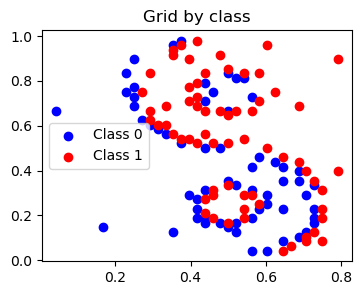

In [7]:
plot_grid(prototypes_X, prototypes_y)

In [6]:
from incrementals import EENTh

eetnh = EENTh(k=3, threshold=0.99)


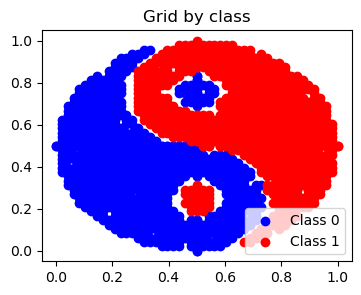

In [7]:
prototypes_X, prototypes_y = eetnh.fit(X_train, y_train)
plot_grid(prototypes_X, prototypes_y)

In [86]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier



class DROP:
    def __init__(self, X, y, sort_type='sort1', k=3):
        """
        Initialize with data and labels
        X: Training data (numpy array)
        y: Training labels (numpy array)
        k: Number of nearest neighbors
        """
        self.X = X
        self.y = y.astype(int)
        self.k = k
        self.sort_type = sort_type
        self.nbrs = KNeighborsClassifier(n_neighbors=k + 1).fit(X,y)
        self.original_indices = list(range(len(X)))
        
    
    def find_neighbors(self, instance_idx, exclude_idx=None):
        """Find k+1 nearest neighbors of a given instance in X, optionally excluding one instance."""
        distances, indices = self.nbrs.kneighbors([self.X[instance_idx]])
        neighbors = indices[0][1:]  # Exclude the instance itself
        if exclude_idx is not None:
            neighbors = [i for i in neighbors if i != exclude_idx]
        return neighbors

    def classify_without(self, idx, exclude_idx):
        """Predict the label of instance `idx` excluding instance `exclude_idx`."""
        distances, indices = self.nbrs.kneighbors([self.X[idx]])
        filtered_indices = [i for i in indices[0] if i != exclude_idx][:self.k]
        return np.argmax(np.bincount(self.y[filtered_indices]))
    
    def drop(self):
        """Perform DROP2 algorithm for instance reduction and return prototypes."""
        S = list(range(len(self.X)))  # Initialize S to include all instances

        if self.sort_type == 'sort3':
            S = self.noise_filtering_pass(S)

        if self.sort_type == 'sort2' or self.sort_type == 'sort3':

            # Step 2: Create a distance list to the nearest enemy for sorting
            distances_to_enemies = {
                i: np.min([self.X[i] - self.X[j] for j in S if self.y[i] != self.y[j]])
                for i in S
            }
            
            # Sort instances in S by the distance to their nearest enemy
            S = sorted(S, key=lambda x: distances_to_enemies[x])
        
        associates = {i: set() for i in S}  # Dictionary to track associates of each instance
        self.nbrs = KNeighborsClassifier(n_neighbors=self.k + 1).fit(self.X[S],self.y[S])
        # Step 1: Build associates list for each instance in S
        for p in S:
            neighbors = self.find_neighbors(p)
            for n in neighbors:
                if n in associates:  # Only add if n already exists in associates
                    associates[n].add(p)  # Add p to each of its neighbors’ lists of associates
                else:
                    associates[n] = {p}  # Initialize a new set for n if not present

        # Step 3: Evaluate each instance in the sorted order
        for p in S[:]:
            with_correct = sum(1 for a in associates[p] if self.classify_without(a, None) == self.y[a])
            # Check associates in the original set T instead of S
            without_correct = sum(1 for a in self.original_indices if a in associates[p] and self.classify_without(a, p) == self.y[a])

            # Remove P if the classification accuracy does not degrade
            if without_correct >= with_correct:
                S.remove(p)  # Remove p from S

                # Update the associates lists and neighbors for each associate of P
                for a in list(associates[p]):  # Use a copy of associates[p] to avoid modifying during iteration
                    if p in associates[a]:
                        associates[a].remove(p)  # Remove P from A’s list of nearest neighbors
                        new_neighbors = self.find_neighbors(a, exclude_idx=p)  # Find new nearest neighbors
                        for new_neighbor in new_neighbors:
                            associates[new_neighbor].add(a)  # Add A to its new neighbor’s list of associates

                # Clean up associates of P itself
                associates[p].clear()

        # Refit KNeighborsClassifier with the reduced set S once at the end
        self.nbrs = KNeighborsClassifier(n_neighbors=self.k + 1).fit(self.X[S], self.y[S])

        # Return X and y subsets based on reduced set S
        X_prototypes = self.X[S]
        y_prototypes = self.y[S]
        return X_prototypes, y_prototypes
    
    def noise_filtering_pass(self, S):
        """Remove noisy instances from S using a rule similar to ENN."""
        for p in S[:]:  # Use a copy of S to avoid modifying it during iteration
            # Count the number of neighbors that classify the instance correctly
            if self.classify_without(p, None) != self.y[p]:
                # If misclassified, remove it from S
                S.remove(p)
        return S
    
    def drop3(self):
        """Perform DROP3 algorithm for instance reduction and return prototypes."""
        S = list(range(len(self.X)))  # Initialize S to include all instances

        # Step 1: Noise filtering pass
        S = self.noise_filtering_pass(S)

        # Step 2: Create a distance list to the nearest enemy for sorting
        distances_to_enemies = {
            i: np.min([np.linalg.norm(self.X[i] - self.X[j]) for j in S if self.y[i] != self.y[j]])
            for i in S
        }
        
        # Sort instances in S by the distance to their nearest enemy
        sorted_S = sorted(S, key=lambda x: distances_to_enemies[x])

        # Step 3: Evaluate each instance in the sorted order
        associates = {i: set() for i in S}  # Dictionary to track associates of each instance
        
        # Build associates list for each instance in S
        

        for p in S:
            neighbors = self.find_neighbors(p)
            for n in neighbors:
                if n in associates:  # Only add if n already exists in associates
                    associates[n].add(p)  # Add p to each of its neighbors’ lists of associates
                else:
                    associates[n] = {p}  # Initialize a new set for n if not present

        for p in sorted_S:
            with_correct = sum(1 for a in associates[p] if self.classify_without(a, None) == self.y[a])
            # Check associates in the original set T instead of S
            without_correct = sum(1 for a in self.original_indices if a in associates[p] and self.classify_without(a, p) == self.y[a])

            # Remove P if the classification accuracy does not degrade
            if without_correct >= with_correct:
                S.remove(p)  # Remove p from S

                # Update the associates lists and neighbors for each associate of P
                for a in list(associates[p]):  # Use a copy of associates[p] to avoid modifying during iteration
                    if p in associates[a]:
                        associates[a].remove(p)  # Remove P from A’s list of nearest neighbors
                        new_neighbors = self.find_neighbors(a, exclude_idx=p)  # Find new nearest neighbors
                        for new_neighbor in new_neighbors:
                            associates[new_neighbor].add(a)  # Add A to its new neighbor’s list of associates

                # Clean up associates of P itself
                associates[p].clear()

        # Refit NearestNeighbors with the reduced set S once at the end
        self.nbrs = KNeighborsClassifier(n_neighbors=self.k + 1).fit(self.X[S], self.y[S])

        # Return X and y subsets based on reduced set S
        X_prototypes = self.X[S]
        y_prototypes = self.y[S]
        return X_prototypes, y_prototypes


In [87]:
drop = DROP(X_train, y_train, sort_type='sort3', k=3)
prototypes_X, prototypes_y = drop.drop()

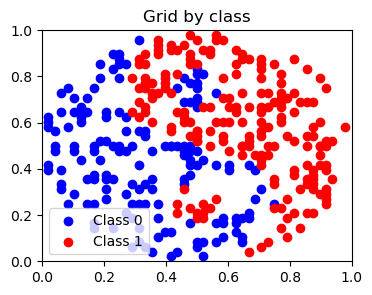

In [88]:
plot_grid(prototypes_X, prototypes_y)

In [87]:
from knn import Distances, Voting_schemes, Weighting
class KNN_GCNN:
    def __init__(self, distance_function, voting_scheme, weight_scheme, k=3, rho=0):
        self.k = k
        self.X_train = None
        self.X_train_weighted = None
        self.y_train = None

        self.distance_functions = {'minkowski1': Distances.minkowski1, 'minkowski2': Distances.minkowski2, 'HEOM': Distances.HEOM}
        self.voting_schemes = {'Majority_class': Voting_schemes.majority_class, 'Inverse_Distance_Weights': Voting_schemes.inverse_distance_weight, 'Sheppards_Work': Voting_schemes.sheppards_work}
        self.weight_schemes = {'Mutual_classifier': Weighting.update_weights_mutual_classifier, 'Relief': Weighting.update_weights_relief, 'ANOVA': Weighting.update_weights_anova}

        self.distance_function = self.distance_functions[distance_function]
        self.voting_scheme = self.voting_schemes[voting_scheme]
        self.weight_scheme = self.weight_schemes[weight_scheme]

        self.class_weights = None
        self.rho = rho

    def compute_class_weights(self, train_labels):
        unique_classes, class_counts = np.unique(train_labels, return_counts=True)
        total_samples = len(train_labels)
        class_weights = {cls: total_samples / count for cls, count in zip(unique_classes, class_counts)}
        return class_weights

    def fit(self, X_train, y_train):

        self.X_train = X_train
        self.y_train = y_train
        self.class_weights = self.compute_class_weights(y_train)
        
        self._reduce(X_train, y_train)

    def get_data(self):
        
        return self.X_train, self.y_train
    
    def _reduce(self, X_train_df, y_train_df):

        X_train = X_train_df.values
        y_train = y_train_df.values

        # CNN Step 1: Initiate with one random prototype for each class
        labels = np.unique(y_train)
        prototypes_X = []
        prototypes_y = []
        for label in labels:
            idx = np.random.choice(np.where(y_train == label)[0])
            prototypes_X.append(X_train[idx])
            prototypes_y.append(y_train[idx])
        
        prototypes_X = np.array(prototypes_X, dtype=object)
        prototypes_y = np.array(prototypes_y, dtype=object)

        # Compute delta_n (GCNN)
        delta_n = self._compute_delta_n(X_train, y_train)

        # Track absorbed samples
        absorbed = np.zeros(X_train.shape[0], dtype=bool)

        # Stop when all samples are absorbed
        while not np.all(absorbed): 
            for i, (x_i, y_i) in enumerate(zip(X_train, y_train)):
                if not absorbed[i]:  # If sample i is not absorbed
                    nearest_homogeneous, nearest_heterogeneous = self._find_nearest_prototypes(x_i, y_i, (
                    prototypes_X, prototypes_y))
                            # CNN absorption criterion (rho=0 corresponds to CNN)
                    if self._should_absorb(nearest_homogeneous, nearest_heterogeneous, x_i, delta_n):
                        absorbed[i] = True
                    else:
                        # If not absorbed, add the sample as a new prototype
                        prototypes_X = np.append(prototypes_X, np.array([x_i]), axis=0)
                        prototypes_y = np.append(prototypes_y, np.array([y_i]), axis=0)
        
        self.X_train = pd.DataFrame(prototypes_X, columns = X_train_df.columns)
        self.y_train = pd.Series(prototypes_y, name = y_train_df.name, dtype=int)

    def _find_nearest_prototypes(self, x, y, prototypes):
        """Find the nearest homogeneous and heterogeneous prototypes."""
        nearest_homogeneous, nearest_heterogeneous = None, None
        min_homogeneous_dist, min_heterogeneous_dist = np.inf, np.inf

        prototypes_X = prototypes[0]
        prototypes_y = prototypes[1]

        for i in range(prototypes_X.shape[0]):
            proto_x, proto_y = prototypes_X[i], prototypes_y[i]
            dist = self.distance_function(x,proto_x)
            if proto_y == y and dist < min_homogeneous_dist:
                nearest_homogeneous = proto_x
                min_homogeneous_dist = dist
            elif proto_y != y and dist < min_heterogeneous_dist:
                nearest_heterogeneous = proto_x
                min_heterogeneous_dist = dist

        return nearest_homogeneous, nearest_heterogeneous

    def _compute_delta_n(self, X, y):
        """Compute delta_n, the minimum distance between samples of different labels."""
        min_distance = np.inf
        for i in range(len(X)):
            for j in range(i + 1, len(X)):
                if y[i] != y[j]:
                    dist = self.distance_function(X[i], X[j])
                    if dist < min_distance:
                        min_distance = dist
        return min_distance
    
    def _should_absorb(self, nearest_homogeneous, nearest_heterogeneous, x, delta_n):
        """GCNN absorption criterion (rho=0 corresponds to CNN)."""
        d_homogeneous = np.linalg.norm(x - nearest_homogeneous)
        d_heterogeneous = np.linalg.norm(x - nearest_heterogeneous)
        return d_homogeneous < d_heterogeneous - self.rho * delta_n


    def predict(self, X_test):

        # Use numpy
        self.X_train_weighted, X_test = self.weight_scheme(self.X_train, self.y_train, X_test)
        predictions = [self._predict(x) for x in X_test.values]
        return predictions

    def _predict(self, x):

        # Calculate distances between x and all examples in the training set
        # Use numpy
        distances = np.array([self.distance_function(x, x_train) for x_train in self.X_train_weighted.values])

        # Get the indices of the k-nearest neighbors
        sorted_indices  = np.argsort(distances)

        k_indices = sorted_indices[:self.k]
        k_nearest_distances = distances[sorted_indices[:self.k]]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Choose between voting schemes
        predicted_class = self.voting_scheme(k_nearest_distances, k_nearest_labels)
        return predicted_class

In [88]:
model = KNN_GCNN('minkowski1', 'Majority_class', 'ANOVA', k=3, rho=0)
model.fit(X_train, y_train)


In [89]:
y_pred = model.predict(X_test)

In [90]:
from utils import computeMetrics

computeMetrics(y_pred, y_test)

(0.5053191489361702,
 array([0.34042553, 0.67021277]),
 array([0.50793651, 0.504     ]),
 array([0.40764331, 0.57534247]))

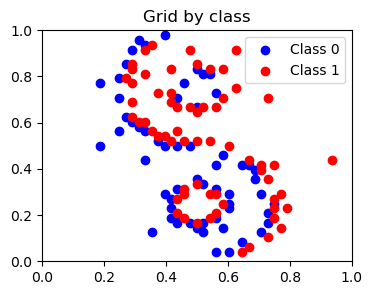

In [91]:
X_train_p, y_train_p = model.get_data()

plot_grid(X_train_p.values, y_train_p.values)

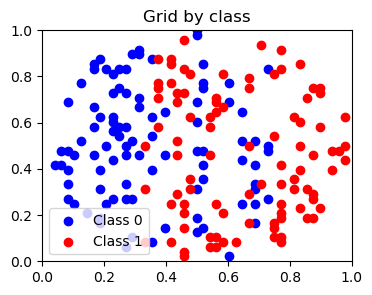

In [86]:
plot_grid(X_test.values, np.array(y_pred))